<a href="https://colab.research.google.com/github/DataScienceAndEngineering/deep-learning-final-project-project-sidewalk/blob/rabiul/notebooks%20/Rabiul/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import argparse
import json
import os
import sys
import xml.etree.ElementTree as et

import numpy as np


In [10]:
#jf = json.load('/content/aachen_000001_000019_gtFine_polygons.json')
#json_ann = json.load(open(os.path.join(root, filename)))
jf  = json.load(open('/content/aachen_000001_000019_gtFine_polygons.json'))
print(jf ) 

{'imgHeight': 1024, 'imgWidth': 2048, 'objects': [{'label': 'sky', 'polygon': [[2047, 155], [1087, 257], [512, 243], [24, 204], [0, 197], [0, 0], [2047, 0]]}, {'label': 'building', 'polygon': [[2046, 3], [1900, 44], [1832, 68], [1825, 76], [1829, 105], [1825, 103], [1824, 99], [1793, 98], [1793, 101], [1758, 101], [1760, 96], [1756, 95], [1753, 93], [1751, 99], [1711, 99], [1711, 96], [1689, 96], [1687, 84], [1669, 87], [1667, 93], [1661, 94], [1639, 95], [1641, 87], [1617, 87], [1616, 71], [1613, 70], [1609, 72], [1610, 89], [1604, 92], [1597, 93], [1593, 88], [1584, 82], [1564, 78], [1558, 72], [1557, 65], [1552, 62], [1551, 41], [1535, 46], [1535, 66], [1529, 69], [1528, 75], [1522, 77], [1521, 77], [1519, 0], [1509, 0], [1511, 25], [1507, 26], [1507, 33], [1509, 32], [1508, 47], [1502, 46], [1502, 80], [1490, 81], [1490, 64], [1483, 70], [1487, 72], [1487, 81], [1482, 83], [1417, 82], [1414, 78], [1411, 83], [1405, 84], [1401, 82], [1401, 85], [1387, 89], [1379, 92], [1381, 74], [1

After using an annotation tool to label your images, export your labels to YOLO format, with one *.txt file per image (if no objects in image, no *.txt file is required). The *.txt file specifications are:

One row per object
Each row is class x_center y_center width height format.
Box coordinates must be in normalized xywh format (from 0 - 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
Class numbers are zero-indexed (start from 0).

# LIb

In [ ]:
%pip install pyquaternion
%pip install pillow
%pip install utils
%pip install object-detection

In [16]:
import cv2
# python imports
from __future__ import print_function, absolute_import, division, unicode_literals
import os, glob, sys, shutil
import argparse
import json
import numpy as np
import argparse
import cv2
# from utils import label_map_util
# from utils import visualization_utils as vis_util
import object_detection.utils 
#from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt



In [ ]:
#upload lib before running this cell
from csHelpers import printError
from labels import id2label, labels
# cityscapes imports
from csHelpers import printError
from json2instanceImg import json2instanceImg

In [18]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
# python imports
from __future__ import print_function, absolute_import, division

In [ ]:
%pip install tf-object-detection-util

In [25]:
import tensorflow as tf

In [26]:
from google.protobuf import text_format

In [32]:
!protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/*.proto: No such file or directory


#cityscapes-to-coco-conversion
https://github.com/TillBeemelmanns/cityscapes-to-coco-conversion/blob/master/main.py

In [35]:
# Image processing
# Check if PIL is actually Pillow as expected
try:
    from PIL import __version__
except:
    print("Please install the module 'Pillow' for image processing, e.g.")
    print("pip install pillow")
    sys.exit(-1)

try:
    import PIL.Image     as Image
    import PIL.ImageDraw as ImageDraw
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)

In [36]:
data_dir = '/content/drive/MyDrive/DL_Project/cityscapesdr'
out_dir = '/content/drive/MyDrive/DL_Project/output/createBB'

In [80]:
sets = ['leftImg8bit/train','leftImg8bit/val']
ann_dirs = ['gtFine/train','gtFine/val']
json_name = 'instancesonly_filtered_%s.json'
polygon_json_file_ending = '_polygons.json'
img_id = 0
ann_id = 0
cat_id = 1
category_dict = {}

category_instancesonly = ['sidewalk',
                          'rail track',
                          'wall',
                          'fence',
                          'guard rail',
                          'pole',
                          'polegroup',
                          'vegetation',
                          'car',
                          'person',
                          'bicycle']

In [73]:
from instance_class import *
from labels import *

In [51]:
for data_set, ann_dir in zip(sets, ann_dirs):
    print('Starting %s' % data_set)
    ann_dict = {}
    images = []
    annotations = []

    for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
        for filename in files:
            if filename.endswith(polygon_json_file_ending):

                if len(images) % 50 == 0:
                    print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                json_ann = json.load(open(os.path.join(root, filename)))

                image = {}
                image['id'] = img_id
                img_id += 1
                image['width'] = json_ann['imgWidth']
                image['height'] = json_ann['imgHeight']
                image['file_name'] = os.path.join("leftImg8bit",
                                                  data_set.split("/")[-1],
                                                  filename.split('_')[0],
                                                  filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                images.append(image)

                fullname = os.path.join(root, image['seg_file_name'])
                print(fullname)
                objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]

                for object_cls in objects:
                    if object_cls not in category_instancesonly:
                        continue  # skip non-instance categories

                    for obj in objects[object_cls]:
                        if obj['contours'] == []:
                            print('Warning: empty contours.')
                            continue  # skip non-instance categories

                        len_p = [len(p) for p in obj['contours']]
                        if min(len_p) <= 4:
                            print('Warning: invalid contours.')
                            continue  # skip non-instance categories

                        ann = {}
                        ann['id'] = ann_id
                        ann_id += 1
                        ann['image_id'] = image['id']
                        ann['segmentation'] = obj['contours']

                        if object_cls not in category_dict:
                            category_dict[object_cls] = cat_id
                            cat_id += 1
                        ann['category_id'] = category_dict[object_cls]
                        ann['iscrowd'] = 0
                        ann['area'] = obj['pixelCount']

                        xyxy_box = poly_to_box(ann['segmentation'])
                        xywh_box = xyxy_to_xywh(xyxy_box)
                        ann['bbox'] = xywh_box

                        annotations.append(ann)

Starting leftImg8bit/train
Processed 0 images, 0 annotations
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000001_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000008_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000009_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000006_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000002_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000004_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000003_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000007_000019_gtFine_instanceIds.png
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFi

In [ ]:
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000001_000019_gtFine_instanceIds.png


In [60]:
convert_cityscapes_instance_only(data_dir, out_dir)

Starting leftImg8bit/train
Processed 0 images, 0 annotations
Num categories: 0
Num images: 22
Num annotations: 0
Starting leftImg8bit/val
Processed 0 images, 0 annotations
Num categories: 0
Num images: 11
Num annotations: 0


## Function

In [40]:
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4
    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

In [69]:
def instances2dict_with_polygons(imageFileList, verbose=False):
    print(imageFileList)
    imgCount     = 0
    instanceDict = {}

    if not isinstance(imageFileList, list):
        imageFileList = [imageFileList]

    if verbose:
        print("Processing {} images...".format(len(imageFileList)))

    for imageFileName in imageFileList:
        # Load image
        img = Image.open(imageFileName)

        # Image as numpy array
        imgNp = np.array(img)

        # Initialize label categories
        instances = {}
        for label in labels:
            instances[label.name] = []

        # Loop through all instance ids in instance image
        for instanceId in np.unique(imgNp):
            if instanceId < 1000:
                continue
            instanceObj = Instance(imgNp, instanceId)
            instanceObj_dict = instanceObj.toDict()

            if id2label[instanceObj.labelID].hasInstances:
                mask = (imgNp == instanceId).astype(np.uint8)
                contour, hier = findContours(
                    mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                polygons = [c.reshape(-1).tolist() for c in contour]
                instanceObj_dict['contours'] = polygons

            instances[id2label[instanceObj.labelID].name].append(instanceObj_dict)

        instanceDict[imageFileName] = instances
        imgCount += 1

        if verbose:
            print("\rImages Processed: {}".format(imgCount), end=' ')
            sys.stdout.flush()

    if verbose:
        print("")

    return instanceDict


In [42]:
def poly_to_box(poly):
    """Convert a polygon into a tight bounding box."""
    x0 = min(min(p[::2]) for p in poly)
    x1 = max(max(p[::2]) for p in poly)
    y0 = min(min(p[1::2]) for p in poly)
    y1 = max(max(p[1::2]) for p in poly)
    box_from_poly = [x0, y0, x1, y1]
    return box_from_poly


In [43]:
def xyxy_to_xywh(xyxy_box):
    xmin, ymin, xmax, ymax = xyxy_box
    TO_REMOVE = 1
    xywh_box = (xmin, ymin, xmax - xmin + TO_REMOVE, ymax - ymin + TO_REMOVE)
    return xywh_box

In [81]:
def convert_cityscapes_instance_only(data_dir, out_dir):
    """Convert from cityscapes format to COCO instance seg format - polygons"""
    sets = [
        'leftImg8bit/train',
        'leftImg8bit/val'
    ]

    ann_dirs = [
        'gtFine/train',
        'gtFine/val',
    ]

    json_name = 'instancesonly_filtered_%s.json'
    polygon_json_file_ending = '_polygons.json'
    img_id = 0
    ann_id = 0
    cat_id = 1
    category_dict = {}
    
    category_instancesonly = ['sidewalk',
                              'rail track',
                              'wall',
                              'fence',
                              'guard rail',
                              'pole',
                              'polegroup',
                              'vegetation',
                              'car',
                              'person',
                              'bicycle']

    for data_set, ann_dir in zip(sets, ann_dirs):
        print('Starting %s' % data_set)
        ann_dict = {}
        images = []
        annotations = []

        for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
            for filename in files:
                if filename.endswith(polygon_json_file_ending):

                    if len(images) % 50 == 0:
                        print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                    json_ann = json.load(open(os.path.join(root, filename)))

                    image = {}
                    image['id'] = img_id
                    img_id += 1
                    image['width'] = json_ann['imgWidth']
                    image['height'] = json_ann['imgHeight']
                    image['file_name'] = os.path.join("leftImg8bit",
                                                      data_set.split("/")[-1],
                                                      filename.split('_')[0],
                                                      filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                    image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                    images.append(image)

                    fullname = os.path.join(root, image['seg_file_name'])
                    print(fullname)
                    objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]
                    print(objects)
                    for object_cls in objects:
                        if object_cls not in category_instancesonly:
                            continue  # skip non-instance categories

                        for obj in objects[object_cls]:
                            if obj['contours'] == []:
                                print('Warning: empty contours.')
                                continue  # skip non-instance categories

                            len_p = [len(p) for p in obj['contours']]
                            if min(len_p) <= 4:
                                print('Warning: invalid contours.')
                                continue  # skip non-instance categories

                            ann = {}
                            ann['id'] = ann_id
                            ann_id += 1
                            ann['image_id'] = image['id']
                            ann['segmentation'] = obj['contours']

                            if object_cls not in category_dict:
                                category_dict[object_cls] = cat_id
                                cat_id += 1
                            ann['category_id'] = category_dict[object_cls]
                            ann['iscrowd'] = 0
                            ann['area'] = obj['pixelCount']

                            xyxy_box = poly_to_box(ann['segmentation'])
                            xywh_box = xyxy_to_xywh(xyxy_box)
                            ann['segmentation'] = xywh_box
                            ann.pop('segmentation')

                            annotations.append(ann)

        ann_dict['images'] = images
        categories = [{"id": category_dict[name], "name": name} for name in category_dict]
        ann_dict['categories'] = categories
        ann_dict['annotations'] = annotations
        print("Num categories: %s" % len(categories))
        print("Num images: %s" % len(images))
        print("Num annotations: %s" % len(annotations))
        print(category_dict)
        if not os.path.exists(os.path.abspath(out_dir)):
            os.mkdir(os.path.abspath(out_dir))
        with open(os.path.join(out_dir, json_name % ann_dir.replace("/", "_")), 'w') as outfile:
            outfile.write(json.dumps(ann_dict))


In [77]:
from instance_class import *
from labels import *

In [82]:
convert_cityscapes_instance_only(data_dir, out_dir)

Starting leftImg8bit/train
Processed 0 images, 0 annotations
/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000001_000019_gtFine_instanceIds.png
['/content/drive/MyDrive/DL_Project/cityscapesdr/gtFine/train/zurich/zurich_000001_000019_gtFine_instanceIds.png']
{'unlabeled': [], 'ego vehicle': [], 'rectification border': [], 'out of roi': [], 'static': [], 'dynamic': [], 'ground': [], 'road': [], 'sidewalk': [], 'parking': [], 'rail track': [], 'building': [], 'wall': [], 'fence': [], 'guard rail': [], 'bridge': [], 'tunnel': [], 'pole': [], 'polegroup': [], 'traffic light': [], 'traffic sign': [], 'vegetation': [], 'terrain': [], 'sky': [], 'person': [{'instID': 24000, 'labelID': 24, 'pixelCount': 13032, 'medDist': -1, 'distConf': 0.0, 'contours': [[1897, 337, 1896, 338, 1895, 338, 1894, 338, 1893, 338, 1892, 338, 1891, 338, 1890, 338, 1889, 339, 1888, 339, 1887, 339, 1886, 339, 1885, 340, 1884, 341, 1883, 342, 1882, 343, 1881, 344, 1880, 345, 1881, 346, 1881,

In [45]:
def parse_args():
    parser = argparse.ArgumentParser(description='Convert dataset')
    parser.add_argument('--dataset', help="cityscapes", default='cityscapes', type=str)
    parser.add_argument('--outdir', help="output dir for json files", default='data/cityscapes/annotations', type=str)
    parser.add_argument('--datadir', help="data dir for annotations to be converted", default="data/cityscapes", type=str)
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()

#pre_process image part 1

 this will produce image and its annotation

In [ ]:
sets = ['leftImg8bit/train','leftImg8bit/val']
ann_dirs = ['gtFine/train','gtFine/val',]
json_name = 'instancesonly_filtered_%s.json'
polygon_json_file_ending = '_polygons.json'
img_id = 0
ann_id = 0
cat_id = 1
category_dict = {}

category_instancesonly = ['sidewalk',
                          'rail track',
                          'wall',
                          'fence',
                          'guard rail',
                          'pole',
                          'polegroup',
                          'vegetation',
                          'car',
                          'bicycle']

In [ ]:
data_dir = '/content/drive/MyDrive/DL_Project/cityscapesdr'
out_dir = '/content/drive/MyDrive/DL_Project/output/createBB'

In [ ]:
for data_set, ann_dir in zip(sets, ann_dirs):
        print('Starting %s' % data_set)
        ann_dict = {}
        images = []
        annotations = []

        #start 
        for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
            for filename in files:
                if filename.endswith(polygon_json_file_ending):

                    if len(images) % 50 == 0:
                        print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                    json_ann = json.load(open(os.path.join(root, filename)))

                    image = {}
                    image['id'] = img_id
                    img_id += 1
                    image['width'] = json_ann['imgWidth']
                    image['height'] = json_ann['imgHeight']
                    image['file_name'] = os.path.join("leftImg8bit",
                                                      data_set.split("/")[-1],
                                                      filename.split('_')[0],
                                                      filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                    image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                    images.append(image)

                    fullname = os.path.join(root, image['seg_file_name'])
                    objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]

                    for object_cls in objects:
                        if object_cls not in category_instancesonly:
                            continue  # skip non-instance categories

                        for obj in objects[object_cls]:
                            if obj['contours'] == []:
                                print('Warning: empty contours.')
                                continue  # skip non-instance categories

                            len_p = [len(p) for p in obj['contours']]
                            if min(len_p) <= 4:
                                print('Warning: invalid contours.')
                                continue  # skip non-instance categories

                            ann = {}
                            ann['id'] = ann_id
                            ann_id += 1
                            ann['image_id'] = image['id']
                            #ann['segmentation'] = obj['contours']

                            if object_cls not in category_dict:
                                category_dict[object_cls] = cat_id
                                cat_id += 1
                            ann['category_id'] = category_dict[object_cls]
                            ann['iscrowd'] = 0
                            ann['area'] = obj['pixelCount']

                            xyxy_box = poly_to_box(ann['segmentation'])
                            xywh_box = xyxy_to_xywh(xyxy_box)
                            ann['bbox'] = xywh_box

                            annotations.append(ann)

        ann_dict['images'] = images
        categories = [{"id": category_dict[name], "name": name} for name in category_dict]
        ann_dict['categories'] = categories
        ann_dict['annotations'] = annotations
        print("Num categories: %s" % len(categories))
        print("Num images: %s" % len(images))
        print("Num annotations: %s" % len(annotations))
        if not os.path.exists(os.path.abspath(out_dir)):
            os.mkdir(os.path.abspath(out_dir))
        with open(os.path.join(out_dir, json_name % ann_dir.replace("/", "_")), 'w') as outfile:
            outfile.write(json.dumps(ann_dict))

Starting leftImg8bit/train


NameError: ignored

In [ ]:
convert_cityscapes_instance_only(args.datadir, args.outdir)

In [ ]:
data_dir = '/content/drive/MyDrive/DL_Project/cityscapes'
out_dir = '/content/drive/MyDrive/DL_Project'

In [ ]:
convert_cityscapes_instance_only(path_input_data, path_output_data)

Starting leftImg8bit/train
Num categories: 0
Num images: 0
Num annotations: 0
Starting leftImg8bit/val
Num categories: 0
Num images: 0
Num annotations: 0


# Function

In [ ]:
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4
    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

In [ ]:
def instances2dict_with_polygons(imageFileList, verbose=False):
    imgCount     = 0
    instanceDict = {}

    if not isinstance(imageFileList, list):
        imageFileList = [imageFileList]

    if verbose:
        print("Processing {} images...".format(len(imageFileList)))

    for imageFileName in imageFileList:
        # Load image
        img = Image.open(imageFileName)

        # Image as numpy array
        imgNp = np.array(img)

        # Initialize label categories
        instances = {}
        for label in labels:
            instances[label.name] = []

        # Loop through all instance ids in instance image
        for instanceId in np.unique(imgNp):
            if instanceId < 1000:
                continue
            instanceObj = Instance(imgNp, instanceId)
            instanceObj_dict = instanceObj.toDict()

            if id2label[instanceObj.labelID].hasInstances:
                mask = (imgNp == instanceId).astype(np.uint8)
                contour, hier = findContours(
                    mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                polygons = [c.reshape(-1).tolist() for c in contour]
                instanceObj_dict['contours'] = polygons

            instances[id2label[instanceObj.labelID].name].append(instanceObj_dict)

        instanceDict[imageFileName] = instances
        imgCount += 1

        if verbose:
            print("\rImages Processed: {}".format(imgCount), end=' ')
            sys.stdout.flush()

    if verbose:
        print("")

    return instanceDict

In [ ]:
def poly_to_box(poly):
    """Convert a polygon into a tight bounding box."""
    x0 = min(min(p[::2]) for p in poly)
    x1 = max(max(p[::2]) for p in poly)
    y0 = min(min(p[1::2]) for p in poly)
    y1 = max(max(p[1::2]) for p in poly)
    box_from_poly = [x0, y0, x1, y1]
    return box_from_poly

In [ ]:
def xyxy_to_xywh(xyxy_box):
    xmin, ymin, xmax, ymax = xyxy_box
    TO_REMOVE = 1
    xywh_box = (xmin, ymin, xmax - xmin + TO_REMOVE, ymax - ymin + TO_REMOVE)
    return xywh_box

In [ ]:
def convert_cityscapes_instance_only(data_dir, out_dir):
    """Convert from cityscapes format to COCO instance seg format - polygons"""
    sets = [
        'leftImg8bit/train',
        'leftImg8bit/val'
    ]

    ann_dirs = [
        'gtFine/train',
        'gtFine/val',
    ]

    json_name = 'instancesonly_filtered_%s.json'
    polygon_json_file_ending = '_polygons.json'
    img_id = 0
    ann_id = 0
    cat_id = 1
    category_dict = {}

    category_instancesonly = [
        'person',
        'rider',
        'car',
        'truck',
        'bus',
        'train',
        'motorcycle',
        'bicycle',
    ]

    for data_set, ann_dir in zip(sets, ann_dirs):
        print('Starting %s' % data_set)
        ann_dict = {}
        images = []
        annotations = []

        for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
            for filename in files:
                if filename.endswith(polygon_json_file_ending):

                    if len(images) % 50 == 0:
                        print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                    json_ann = json.load(open(os.path.join(root, filename)))

                    image = {}
                    image['id'] = img_id
                    img_id += 1
                    image['width'] = json_ann['imgWidth']
                    image['height'] = json_ann['imgHeight']
                    image['file_name'] = os.path.join("leftImg8bit",
                                                      data_set.split("/")[-1],
                                                      filename.split('_')[0],
                                                      filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                    image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                    images.append(image)

                    fullname = os.path.join(root, image['seg_file_name'])
                    objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]

                    for object_cls in objects:
                        if object_cls not in category_instancesonly:
                            continue  # skip non-instance categories

                        for obj in objects[object_cls]:
                            if obj['contours'] == []:
                                print('Warning: empty contours.')
                                continue  # skip non-instance categories

                            len_p = [len(p) for p in obj['contours']]
                            if min(len_p) <= 4:
                                print('Warning: invalid contours.')
                                continue  # skip non-instance categories

                            ann = {}
                            ann['id'] = ann_id
                            ann_id += 1
                            ann['image_id'] = image['id']
                            ann['segmentation'] = obj['contours']

                            if object_cls not in category_dict:
                                category_dict[object_cls] = cat_id
                                cat_id += 1
                            ann['category_id'] = category_dict[object_cls]
                            ann['iscrowd'] = 0
                            ann['area'] = obj['pixelCount']

                            xyxy_box = poly_to_box(ann['segmentation'])
                            xywh_box = xyxy_to_xywh(xyxy_box)
                            ann['bbox'] = xywh_box

                            annotations.append(ann)

        ann_dict['images'] = images
        categories = [{"id": category_dict[name], "name": name} for name in category_dict]
        ann_dict['categories'] = categories
        ann_dict['annotations'] = annotations
        print("Num categories: %s" % len(categories))
        print("Num images: %s" % len(images))
        print("Num annotations: %s" % len(annotations))
        if not os.path.exists(os.path.abspath(out_dir)):
            os.mkdir(os.path.abspath(out_dir))
        with open(os.path.join(out_dir, json_name % ann_dir.replace("/", "_")), 'w') as outfile:
            outfile.write(json.dumps(ann_dict))


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description='Convert dataset')
    parser.add_argument('--dataset', help="cityscapes", default='cityscapes', type=str)
    parser.add_argument('--outdir', help="output dir for json files", default='data/cityscapes/annotations', type=str)
    parser.add_argument('--datadir', help="data dir for annotations to be converted", default="data/cityscapes", type=str)
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()

# Function 2

In [ ]:
# Image processing
# Check if PIL is actually Pillow as expected
try:
    from PIL import __version__
except:
    print("Please install the module 'Pillow' for image processing, e.g.")
    print("pip install pillow")
    sys.exit(-1)

try:
    import PIL.Image     as Image
    import PIL.ImageDraw as ImageDraw
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)

## Lib Error

In [ ]:
#from utils.instance_class import *
#from utils.labels import *

In [ ]:
# The main method
def convert2panoptic(cityscapesPath=None, outputFolder=None, useTrainId=False, setNames=["val", "train", "test"]):
    # Where to look for Cityscapes
    if cityscapesPath is None:
        if 'CITYSCAPES_DATASET' in os.environ:
            cityscapesPath = os.environ['CITYSCAPES_DATASET']
        else:
            cityscapesPath = os.path.join(os.path.dirname(os.path.realpath(__file__)),'..','..')
        cityscapesPath = os.path.join(cityscapesPath, "gtFine")

    if outputFolder is None:
        outputFolder = cityscapesPath

    categories = []
    for label in labels:
        if label.ignoreInEval:
            continue
        categories.append({'id': int(label.trainId) if useTrainId else int(label.id),
                           'name': label.name,
                           'color': label.color,
                           'supercategory': label.category,
                           'isthing': 1 if label.hasInstances else 0})

    for setName in setNames:
        # how to search for all ground truth
        searchFine   = os.path.join(cityscapesPath, setName, "*", "*_instanceIds.png")
        # search files
        filesFine = glob.glob(searchFine)
        filesFine.sort()

        files = filesFine
        # quit if we did not find anything
        if not files:
            printError(
                "Did not find any files for {} set using matching pattern {}. Please consult the README.".format(setName, searchFine)
            )
        # a bit verbose
        print("Converting {} annotation files for {} set.".format(len(files), setName))

        trainIfSuffix = "_trainId" if useTrainId else ""
        outputBaseFile = "cityscapes_panoptic_{}{}".format(setName, trainIfSuffix)
        outFile = os.path.join(outputFolder, "{}.json".format(outputBaseFile))
        print("Json file with the annotations in panoptic format will be saved in {}".format(outFile))
        panopticFolder = os.path.join(outputFolder, outputBaseFile)
        if not os.path.isdir(panopticFolder):
            print("Creating folder {} for panoptic segmentation PNGs".format(panopticFolder))
            os.mkdir(panopticFolder)
        print("Corresponding segmentations in .png format will be saved in {}".format(panopticFolder))

        images = []
        annotations = []
        for progress, f in enumerate(files):

            originalFormat = np.array(Image.open(f))

            fileName = os.path.basename(f)
            imageId = fileName.replace("_gtFine_instanceIds.png", "")
            inputFileName = fileName.replace("_instanceIds.png", "_leftImg8bit.png")
            outputFileName = fileName.replace("_instanceIds.png", "_panoptic.png")
            # image entry, id for image is its filename without extension
            images.append({"id": imageId,
                           "width": int(originalFormat.shape[1]),
                           "height": int(originalFormat.shape[0]),
                           "file_name": inputFileName})

            pan_format = np.zeros(
                (originalFormat.shape[0], originalFormat.shape[1], 3), dtype=np.uint8
            )

            segmentIds = np.unique(originalFormat)
            segmInfo = []
            for segmentId in segmentIds:
                if segmentId < 1000:
                    semanticId = segmentId
                    isCrowd = 1
                else:
                    semanticId = segmentId // 1000
                    isCrowd = 0
                labelInfo = id2label[semanticId]
                categoryId = labelInfo.trainId if useTrainId else labelInfo.id
                if labelInfo.ignoreInEval:
                    continue
                if not labelInfo.hasInstances:
                    isCrowd = 0

                mask = originalFormat == segmentId
                color = [segmentId % 256, segmentId // 256, segmentId // 256 // 256]
                pan_format[mask] = color

                area = np.sum(mask) # segment area computation

                # bbox computation for a segment
                hor = np.sum(mask, axis=0)
                hor_idx = np.nonzero(hor)[0]
                x = hor_idx[0]
                width = hor_idx[-1] - x + 1
                vert = np.sum(mask, axis=1)
                vert_idx = np.nonzero(vert)[0]
                y = vert_idx[0]
                height = vert_idx[-1] - y + 1
                bbox = [int(x), int(y), int(width), int(height)]

                segmInfo.append({"id": int(segmentId),
                                 "category_id": int(categoryId),
                                 "area": int(area),
                                 "bbox": bbox,
                                 "iscrowd": isCrowd})

            annotations.append({'image_id': imageId,
                                'file_name': outputFileName,
                                "segments_info": segmInfo})

            Image.fromarray(pan_format).save(os.path.join(panopticFolder, outputFileName))

            print("\rProgress: {:>3.2f} %".format((progress + 1) * 100 / len(files)), end=' ')
            sys.stdout.flush()

        print("\nSaving the json file {}".format(outFile))
        d = {'images': images,
             'annotations': annotations,
             'categories': categories}
        with open(outFile, 'w') as f:
            json.dump(d, f, sort_keys=True, indent=4)





In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset-folder",
                        dest="cityscapesPath",
                        help="path to the Cityscapes dataset 'gtFine' folder",
                        default=None,
                        type=str)
    parser.add_argument("--output-folder",
                        dest="outputFolder",
                        help="path to the output folder.",
                        default=None,
                        type=str)
    parser.add_argument("--use-train-id", action="store_true", dest="useTrainId")
    parser.add_argument("--set-names",
                        dest="setNames",
                        help="set names to which apply the function to",
                        nargs='+',
                        default=["val", "train", "test"],
                        type=str)
    args = parser.parse_args()

    convert2panoptic(args.cityscapesPath, args.outputFolder, args.useTrainId, args.setNames)

In [ ]:
# The main method
def main():
    # Where to look for Cityscapes
    if 'CITYSCAPES_DATASET' in os.environ:
        cityscapesPath = os.environ['CITYSCAPES_DATASET']
    else:
        cityscapesPath = os.path.join(os.path.dirname(os.path.realpath(__file__)),'..','..')
    # how to search for all ground truth
    searchFine   = os.path.join( cityscapesPath , "gtFine"   , "*" , "*" , "*_gt*_polygons.json" )
    searchCoarse = os.path.join( cityscapesPath , "gtCoarse" , "*" , "*" , "*_gt*_polygons.json" )

    # search files
    filesFine = glob.glob( searchFine )
    filesFine.sort()
    filesCoarse = glob.glob( searchCoarse )
    filesCoarse.sort()

    # concatenate fine and coarse
    files = filesFine + filesCoarse
    # files = filesFine # use this line if fine is enough for now.

    # quit if we did not find anything
    if not files:
        printError( "Did not find any files. Please consult the README." )

    # a bit verbose
    print("Processing {} annotation files".format(len(files)))

    # iterate through files
    progress = 0
    print("Progress: {:>3} %".format( progress * 100 / len(files) ), end=' ')
    for f in files:
        # create the output filename
        dst = f.replace( "_polygons.json" , "_instanceTrainIds.png" )

        # do the conversion
        try:
            json2instanceImg( f , dst , "trainIds" )
        except:
            print("Failed to convert: {}".format(f))
            raise

        # status
        progress += 1
        print("\rProgress: {:>3} %".format( progress * 100 / len(files) ), end=' ')
        sys.stdout.flush()

In [ ]:
def findContours(*args, **kwargs):
    """
    Wraps cv2.findContours to maintain compatiblity between versions
    3 and 4
    Returns:
        contours, hierarchy
    """
    if cv2.__version__.startswith('4'):
        contours, hierarchy = cv2.findContours(*args, **kwargs)
    elif cv2.__version__.startswith('3'):
        _, contours, hierarchy = cv2.findContours(*args, **kwargs)
    else:
        raise AssertionError(
            'cv2 must be either version 3 or 4 to call this method')

    return contours, hierarchy

def instances2dict_with_polygons(imageFileList, verbose=False):
    imgCount     = 0
    instanceDict = {}

    if not isinstance(imageFileList, list):
        imageFileList = [imageFileList]

    if verbose:
        print("Processing {} images...".format(len(imageFileList)))

    for imageFileName in imageFileList:
        # Load image
        img = Image.open(imageFileName)

        # Image as numpy array
        imgNp = np.array(img)

        # Initialize label categories
        instances = {}
        for label in labels:
            instances[label.name] = []

        # Loop through all instance ids in instance image
        for instanceId in np.unique(imgNp):
            if instanceId < 1000:
                continue
            instanceObj = Instance(imgNp, instanceId)
            instanceObj_dict = instanceObj.toDict()

            if id2label[instanceObj.labelID].hasInstances:
                mask = (imgNp == instanceId).astype(np.uint8)
                contour, hier = findContours(
                    mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

                polygons = [c.reshape(-1).tolist() for c in contour]
                instanceObj_dict['contours'] = polygons

            instances[id2label[instanceObj.labelID].name].append(instanceObj_dict)

        instanceDict[imageFileName] = instances
        imgCount += 1

        if verbose:
            print("\rImages Processed: {}".format(imgCount), end=' ')
            sys.stdout.flush()

    if verbose:
        print("")

    return instanceDict

def poly_to_box(poly):
    """Convert a polygon into a tight bounding box."""
    x0 = min(min(p[::2]) for p in poly)
    x1 = max(max(p[::2]) for p in poly)
    y0 = min(min(p[1::2]) for p in poly)
    y1 = max(max(p[1::2]) for p in poly)
    box_from_poly = [x0, y0, x1, y1]
    return box_from_poly

def xyxy_to_xywh(xyxy_box):
    xmin, ymin, xmax, ymax = xyxy_box
    TO_REMOVE = 1
    xywh_box = (xmin, ymin, xmax - xmin + TO_REMOVE, ymax - ymin + TO_REMOVE)
    return xywh_box

def convert_cityscapes_instance_only(data_dir, out_dir):
    """Convert from cityscapes format to COCO instance seg format - polygons"""
    sets = [
        'leftImg8bit/train',
        'leftImg8bit/val'
    ]

    ann_dirs = [
        'gtFine/train',
        'gtFine/val',
    ]

    json_name = 'instancesonly_filtered_%s.json'
    polygon_json_file_ending = '_polygons.json'
    img_id = 0
    ann_id = 0
    cat_id = 1
    category_dict = {}

    category_instancesonly = [
        'person',
        'rider',
        'car',
        'truck',
        'bus',
        'train',
        'motorcycle',
        'bicycle',
    ]

    for data_set, ann_dir in zip(sets, ann_dirs):
        print('Starting %s' % data_set)
        ann_dict = {}
        images = []
        annotations = []

        for root, _, files in os.walk(os.path.join(data_dir, ann_dir)):
            for filename in files:
                if filename.endswith(polygon_json_file_ending):

                    if len(images) % 50 == 0:
                        print("Processed %s images, %s annotations" % (len(images), len(annotations)))

                    json_ann = json.load(open(os.path.join(root, filename)))

                    image = {}
                    image['id'] = img_id
                    img_id += 1
                    image['width'] = json_ann['imgWidth']
                    image['height'] = json_ann['imgHeight']
                    image['file_name'] = os.path.join("leftImg8bit",
                                                      data_set.split("/")[-1],
                                                      filename.split('_')[0],
                                                      filename.replace("_gtFine_polygons.json", '_leftImg8bit.png'))
                    image['seg_file_name'] = filename.replace("_polygons.json", "_instanceIds.png")
                    images.append(image)

                    fullname = os.path.join(root, image['seg_file_name'])
                    objects = instances2dict_with_polygons([fullname], verbose=False)[fullname]

                    for object_cls in objects:
                        if object_cls not in category_instancesonly:
                            continue  # skip non-instance categories

                        for obj in objects[object_cls]:
                            if obj['contours'] == []:
                                print('Warning: empty contours.')
                                continue  # skip non-instance categories

                            len_p = [len(p) for p in obj['contours']]
                            if min(len_p) <= 4:
                                print('Warning: invalid contours.')
                                continue  # skip non-instance categories

                            ann = {}
                            ann['id'] = ann_id
                            ann_id += 1
                            ann['image_id'] = image['id']
                            ann['segmentation'] = obj['contours']

                            if object_cls not in category_dict:
                                category_dict[object_cls] = cat_id
                                cat_id += 1
                            ann['category_id'] = category_dict[object_cls]
                            ann['iscrowd'] = 0
                            ann['area'] = obj['pixelCount']

                            xyxy_box = poly_to_box(ann['segmentation'])
                            xywh_box = xyxy_to_xywh(xyxy_box)
                            ann['bbox'] = xywh_box

                            annotations.append(ann)

        ann_dict['images'] = images
        categories = [{"id": category_dict[name], "name": name} for name in category_dict]
        ann_dict['categories'] = categories
        ann_dict['annotations'] = annotations
        print("Num categories: %s" % len(categories))
        print("Num images: %s" % len(images))
        print("Num annotations: %s" % len(annotations))
        if not os.path.exists(os.path.abspath(out_dir)):
            os.mkdir(os.path.abspath(out_dir))
        with open(os.path.join(out_dir, json_name % ann_dir.replace("/", "_")), 'w') as outfile:
            outfile.write(json.dumps(ann_dict))


def parse_args():
    parser = argparse.ArgumentParser(description='Convert dataset')
    parser.add_argument('--dataset', help="cityscapes", default='cityscapes', type=str)
    parser.add_argument('--outdir', help="output dir for json files", default='data/cityscapes/annotations', type=str)
    parser.add_argument('--datadir', help="data dir for annotations to be converted", default="data/cityscapes", type=str)
    if len(sys.argv) == 1:
        parser.print_help()
        sys.exit(1)
    return parser.parse_args()


if __name__ == '__main__':
    args = parse_args()
    if args.dataset == "cityscapes":
        convert_cityscapes_instance_only(args.datadir, args.outdir)
    else:
        print("Dataset not supported: %s" % args.dataset)

In [ ]:
#!/usr/bin/python
#
# Instance class
#

class Instance(object):
    instID     = 0
    labelID    = 0
    pixelCount = 0
    medDist    = -1
    distConf   = 0.0

    def __init__(self, imgNp, instID):
        if (instID == -1):
            return
        self.instID     = int(instID)
        self.labelID    = int(self.getLabelID(instID))
        self.pixelCount = int(self.getInstancePixels(imgNp, instID))

    def getLabelID(self, instID):
        if (instID < 1000):
            return instID
        else:
            return int(instID / 1000)

    def getInstancePixels(self, imgNp, instLabel):
        return (imgNp == instLabel).sum()

    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

    def toDict(self):
        buildDict = {}
        buildDict["instID"]     = self.instID
        buildDict["labelID"]    = self.labelID
        buildDict["pixelCount"] = self.pixelCount
        buildDict["medDist"]    = self.medDist
        buildDict["distConf"]   = self.distConf
        return buildDict

    def fromJSON(self, data):
        self.instID     = int(data["instID"])
        self.labelID    = int(data["labelID"])
        self.pixelCount = int(data["pixelCount"])
        if ("medDist" in data):
            self.medDist    = float(data["medDist"])
            self.distConf   = float(data["distConf"])

    def __str__(self):
        return "("+str(self.instID)+")"


# Other

In [ ]:

json_path = '/content/aachen_000170_000019_gtFine_polygons.json'
img_path = '/content/aachen_000170_000019_leftImg8bit.png'

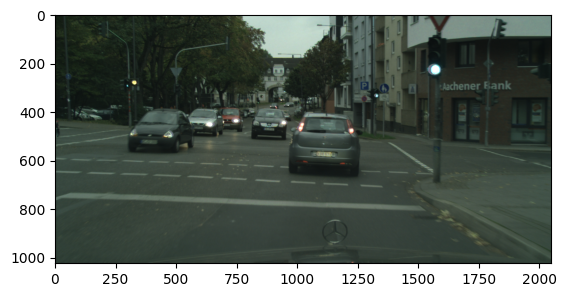

In [ ]:
image = Image.open(img_path)
plt.imshow(image)
instance_data = json.load(open(json_path))

In [ ]:
instance_data

{'imgHeight': 1024,
 'imgWidth': 2048,
 'objects': [{'label': 'road',
   'polygon': [[0, 737],
    [0, 461],
    [326, 472],
    [342, 448],
    [715, 377],
    [805, 374],
    [863, 369],
    [877, 354],
    [909, 356],
    [952, 352],
    [937, 366],
    [953, 371],
    [1010, 369],
    [1066, 361],
    [1063, 327],
    [1105, 326],
    [1099, 380],
    [1081, 419],
    [1125, 452],
    [1403, 497],
    [1610, 532],
    [2047, 556],
    [2047, 1023],
    [259, 1023],
    [0, 1023]]},
  {'label': 'sky',
   'polygon': [[0, 54], [843, 216], [1224, 218], [1376, 0], [0, 0]]},
  {'label': 'static',
   'polygon': [[892, 365],
    [963, 363],
    [970, 359],
    [967, 341],
    [906, 339],
    [887, 349],
    [890, 358],
    [889, 362]]},
  {'label': 'building',
   'polygon': [[593, 169],
    [976, 180],
    [977, 168],
    [984, 168],
    [984, 179],
    [985, 180],
    [1105, 176],
    [1106, 65],
    [1126, 65],
    [1126, 70],
    [1132, 69],
    [1131, 10],
    [1141, 0],
    [2047, 0],

In [ ]:
label_keep = {
    'sidewalk': 8,
    'pole': 17,
    'car': 26,
    'bicycle': 33
    }

In [ ]:
instance_data['objects'][0]

{'label': 'ego vehicle',
 'polygon': [[271, 1023],
  [387, 1009],
  [549, 993],
  [821, 966],
  [1082, 950],
  [1142, 947],
  [1112, 932],
  [1096, 896],
  [1108, 861],
  [1137, 844],
  [1175, 844],
  [1204, 867],
  [1209, 897],
  [1195, 931],
  [1161, 945],
  [1376, 957],
  [1654, 977],
  [1883, 1002],
  [2028, 1023]]}

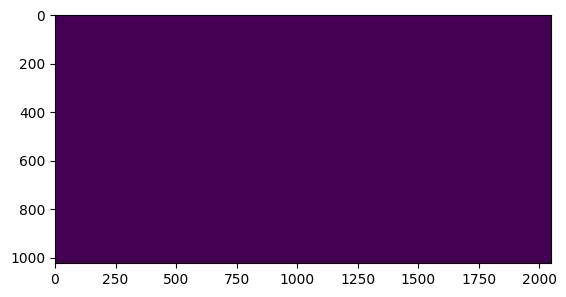

In [ ]:
img = Image.new('L', (2048, 1024), 0)
plt.imshow(img)

In [ ]:
img_map = {}
for i in instance_data['objects']:
    if i['label'] in label_keep.keys():
        polygon = i['polygon']
        xy = [(p[0], p[1]) for p in polygon]
        ImageDraw.Draw(img).polygon(xy,fill=j)
        img_map[j] = i['label']
        j+=1


        


In [ ]:
k =0
extracted_car = np.empty((1024, 2048, 3))
for i in img_map.values():
    if i == 'car':
        idx = (np.array(img)==list(img_map.keys())[k])
        if idx.sum() > 12000:
            extracted_car[idx] = np.array(image)[idx]
            break
    k+=1

In [ ]:
nonzero_indices = np.nonzero(extracted_car)
min_indices = np.min(nonzero_indices, axis=1)
max_indices = np.max(nonzero_indices, axis=1)
# Crop the object array to remove padding zeros
cropped = extracted_car[min_indices[0]:max_indices[0]+1, min_indices[1]:max_indices[1]+1, ...]



In [ ]:
cropped = np.clip(cropped, 0, 255).astype(np.uint8)
plt.imshow(cropped)

car_size = cropped.shape[:-1]
k=0

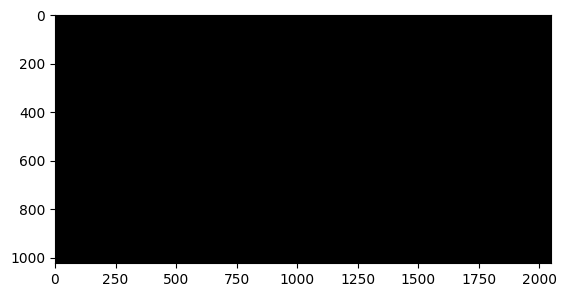

In [ ]:
plt.imshow(extracted_car)

# 1

In [ ]:
j = json.load(open('/content/drive/MyDrive/DL_Project/cityscapes_panoptic_train.json'))

In [ ]:
u ={'area': 831082, 'bbox': [6, 488, 2037, 531], 'category_id': 7, 'id': 7, 'iscrowd': 0}

In [ ]:
u['bbox'].text()

AttributeError: ignored

In [ ]:
                with open(os.path.join(DATA_OUT_DIR, set_, 'anns', '{}.txt'.format(id)), 'a') as f_ann:
                    # class_id, xc, yx, w, h
                    x1, y1, y2 = [float(j) for j in [x1, x2, y1, y2]]
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1

                    f_ann.write('0 {} {} {} {}\n'.format(xc, yc, w, h))
                    f_ann.close()

'/content'

### BBOX

In [ ]:
for x in [8,10,12,13,14,17,18,21,26,33]:
  print(h[x])

0
1
2
3
4
5
6
8
8
9


In [ ]:
classes = [8,10,12,13,14,17,18,21,26,33]
classes_dic_conv = {8:0, 10:1, 12:2, 13:3, 14:4, 17:5, 18:6, 21:8, 26:8, 33:9}
if 'annotations' in j:
  for x in j['annotations']:
    file_name, sg = x['file_name'].split('.')[0], x['segments_info']
    file_path = '/content/drive/MyDrive/DL_Project/output/label/{}.txt'.format(file_name)
    #print(file_path)
    text = ''
    for cl in sg:
      if cl['category_id'] not in classes:
        continue
      x1, y1, x2, y2 = [float(j) for j in cl['bbox']]
      x1, y1, x2, y2 = x1/255, y1/255, x2/255, y2/255
      xc = (x1 + x2) / 2
      yc = (y1 + y2) / 2
      w = x2 - x1
      h = y2 - y1
      text += '{} {} {} {} {}\n'.format(classes_dic_conv[cl['category_id']],xc, yc, w, h)
    #print(text)
    #break
    with open(file_path, 'w') as f:
      f.write(text)
      f.close()

In [ ]:
[1597, 266, 446, 254]/255

TypeError: ignored

In [ ]:
classes = [8,10,12,13,14,17,18,21,26,33]
if 'annotations' in j:
  for x in j['annotations']:
    file_name, sg = x['file_name'].split('.')[0], x['segments_info']
    file_path = '/content/drive/MyDrive/DL_Project/output/label/{}.txt'.format(file_name)
    #print(file_path)
    text = ''
    for cl in sg:
      if cl['category_id'] not in classes:
        continue
      x1, y1, x2, y2 = [float(j) for j in cl['bbox']]
      xc = (x1 + x2) / 2
      yc = (y1 + y2) / 2
      w = x2 - x1
      h = y2 - y1
      text += '{} {} {} {} {}\n'.format(cl['category_id'],xc/255, yc/255, w/255, h/255)
    print(text)
    #with open(file_path, 'w') as f:
      #f.write(text)
      #f.close()

8 4.0058823529411764 1.0862745098039215 5.6196078431372545 -1.4666666666666666
17 3.792156862745098 1.1509803921568627 7.427450980392157 2.2627450980392156
21 4.0058823529411764 1.0196078431372548 7.964705882352941 2.0
26 4.0058823529411764 1.0235294117647058 -7.407843137254902 -1.780392156862745
26 3.256862745098039 0.9784313725490196 -5.345098039215686 -1.5411764705882354
26 3.2058823529411766 1.007843137254902 -5.188235294117647 -1.5607843137254902
26 3.768627450980392 0.9549019607843138 -7.176470588235294 -1.8705882352941177
26 3.835294117647059 1.0058823529411764 -7.043137254901961 -1.8
26 3.6294117647058823 0.9980392156862745 -6.23921568627451 -1.5333333333333334
26 0.5980392156862745 0.984313725490196 0.058823529411764705 -1.396078431372549
26 1.584313725490196 1.0431372549019609 -1.607843137254902 -1.2078431372549019
33 1.6254901960784314 0.9607843137254902 -2.9607843137254903 -1.576470588235294
33 3.6823529411764704 1.072549019607843 -7.0588235294117645 -1.5254901960784313

8 

In [ ]:
if 'annotations' in j:
  for x in j['annotations']:
    file_name, sg = x['file_name'].split('.')[0], x['segments_info']
    print(file_name)
    for cl in sg:
      file_path = '/content/drive/MyDrive/DL_Project/output/{}.txt'.format(file_name)
      text = text(cl['category_id'],cl['bbox'])
      print(text)
      with open(file_path, 'w') as f:
        f.write(text)
    break

In [ ]:
file_path = '/content/drive/MyDrive/DL_Project/output/{}.txt'.format('d')
with open('/content/drive/MyDrive/DL_Project/output/label/readme.txt', 'w') as f:
    f.write('Create a new text file!')

3

In [ ]:
file_path = '/content/drive/MyDrive/DL_Project/output/{}.txt'.format('d')
file_path

'/content/drive/MyDrive/DL_Project/output/d.txt'

In [ ]:
for jj in j:
  print(jj)

annotations
categories
images


In [ ]:
len(j['annotations'])

22

In [ ]:
for x in j['annotations']:
  print(x)

{'file_name': 'aachen_000000_000019_gtFine_panoptic.png', 'image_id': 'aachen_000000_000019', 'segments_info': [{'area': 831082, 'bbox': [6, 488, 2037, 531], 'category_id': 7, 'id': 7, 'iscrowd': 0}, {'area': 29195, 'bbox': [305, 464, 1738, 90], 'category_id': 8, 'id': 8, 'iscrowd': 0}, {'area': 611938, 'bbox': [6, 5, 2037, 494], 'category_id': 11, 'id': 11, 'iscrowd': 0}, {'area': 22846, 'bbox': [20, 5, 1914, 582], 'category_id': 17, 'id': 17, 'iscrowd': 0}, {'area': 34863, 'bbox': [38, 247, 2005, 238], 'category_id': 20, 'id': 20, 'iscrowd': 0}, {'area': 221654, 'bbox': [6, 5, 2037, 515], 'category_id': 21, 'id': 21, 'iscrowd': 0}, {'area': 130185, 'bbox': [6, 475, 2037, 376], 'category_id': 22, 'id': 22, 'iscrowd': 0}, {'area': 38722, 'bbox': [6, 5, 1994, 135], 'category_id': 23, 'id': 23, 'iscrowd': 0}, {'area': 665, 'bbox': [892, 446, 21, 52], 'category_id': 24, 'id': 24000, 'iscrowd': 0}, {'area': 923, 'bbox': [901, 444, 34, 54], 'category_id': 24, 'id': 24001, 'iscrowd': 0}, {'a

In [ ]:


DATA_ALL_DIR = os.path.join('.', 'data_all')

DATA_OUT_DIR = os.path.join('.', 'data')

for set_ in ['train', 'validation', 'test']:
    for dir_ in [os.path.join(DATA_OUT_DIR, set_),
                 os.path.join(DATA_OUT_DIR, set_, 'imgs'),
                 os.path.join(DATA_OUT_DIR, set_, 'anns')]:
        if os.path.exists(dir_):
            shutil.rmtree(dir_)
        os.mkdir(dir_)

alpaca_id = '/m/0pcr'

train_bboxes_filename = os.path.join('.', 'oidv6-train-annotations-bbox.csv')
validation_bboxes_filename = os.path.join('.', 'validation-annotations-bbox.csv')
test_bboxes_filename = os.path.join('.', 'test-annotations-bbox.csv')


for j, filename in enumerate([train_bboxes_filename, validation_bboxes_filename, test_bboxes_filename]):
    set_ = ['train', 'validation', 'test'][j]
    print(filename)
    with open(filename, 'r') as f:
        line = f.readline()
        while len(line) != 0:
            id, _, class_name, _, x1, x2, y1, y2, _, _, _, _, _ = line.split(',')[:13]
            if class_name in [alpaca_id]:
                if not os.path.exists(os.path.join(DATA_OUT_DIR, set_, 'imgs', '{}.jpg'.format(id))):
                    shutil.copy(os.path.join(DATA_ALL_DIR, '{}.jpg'.format(id)),
                                os.path.join(DATA_OUT_DIR, set_, 'imgs', '{}.jpg'.format(id)))
                with open(os.path.join(DATA_OUT_DIR, set_, 'anns', '{}.txt'.format(id)), 'a') as f_ann:
                    # class_id, xc, yx, w, h
                    x1, x2, y1, y2 = [float(j) for j in [x1, x2, y1, y2]]
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1

                    f_ann.write('0 {} {} {} {}\n'.format(xc, yc, w, h))
                    f_ann.close()

            line = f.readline()

# YOLO V8

In [ ]:
!pip install ultralytics

In [ ]:

import os

from ultralytics import YOLO

In [ ]:
ROOT_DIR = '/content/drive/MyDrive/DL_Project/output/datadir'

In [ ]:
# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
results = model.train(data=os.path.join(ROOT_DIR, "google_colab_config.yaml"), epochs=1)  # train the model

Ultralytics YOLOv8.0.99 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/DL_Project/output/datadir/google_colab_config.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False

FileNotFoundError: ignored